I will use this notebook to demonstrate some calculations of photon emission properties from a nanofiber-trapped neutral atom system using MEEP and plotting in Julia.

In [ ]:
run(pipeline(`mpirun -n 6 meep-mpi "nanofiber.ctl"`, "nanofiber.out"))

# Local field evolution

This should be obtained by setting up a point-monitor at the dipole position and append time-dependent field components in some short periods. 
The data is stored in the `nanofiber-Ert.h5` file.
Now we plot out the time-dependent evolution of the field at the dipole position.

In [1]:
run(`h5ls data/nanofiber-Ert-ex.h5`)

ex.i                     Dataset {1200/Inf}
ex.r                     Dataset {1200/Inf}
ey.i                     Dataset {1200/Inf}
ey.r                     Dataset {1200/Inf}
ez.i                     Dataset {1200/Inf}
ez.r                     Dataset {1200/Inf}


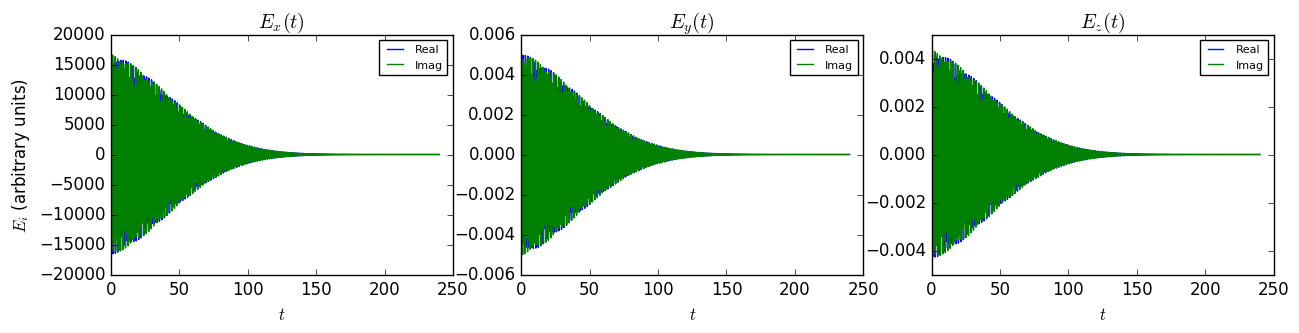

1
(1200,)


6.676845942248247e-16

In [2]:
using PyPlot
using HDF5
ex = h5read("data/nanofiber-Ert-ex.h5", "ex.r") + im*h5read("data/nanofiber-Ert-ex.h5", "ex.i")
ey = h5read("data/nanofiber-Ert-ex.h5", "ey.r") + im*h5read("data/nanofiber-Ert-ex.h5", "ey.i")
ez = h5read("data/nanofiber-Ert-ex.h5", "ez.r") + im*h5read("data/nanofiber-Ert-ex.h5", "ez.i")
println(ndims(ex)) # Print out the dimension of the variables to check if it's a vector (output 1). Otherwise, use permutedims to flip the data dimension.
ex = ex[end:-1:1]; ey = ey[end:-1:1]; ez = ez[end:-1:1];
println(size(ex))
lent=length(ex)
t=linspace(0,240.0,lent)
figure(figsize=(15,3))
subplot(1,3,1)
ax=plot(t,real(ex))
plot(t,imag(ex))
title("\$E_x(t)\$ ")
xlabel(L"t")
ylabel(L"$E_i$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,2)
ax=plot(t,real(ey))
plot(t,imag(ey))
title("\$E_y(t)\$")
xlabel(L"t")
#ylabel(L"$E_y$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,3)
ax=plot(t,real(ez))
plot(t,imag(ez))
title("\$E_z(t)\$")
xlabel(L"t")
#ylabel(L"$E_z$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

a=1.0e-6; c=2.99792458e8; t_unit=a/c;
deltaT=240.0*t_unit/(lent-1) # $\delta T$ in SI units. In MEEP, T is scaled by t_unit=a/c where a is the unit of length.

Now we can plot out the detected signal in the frequency domain correspondingly.

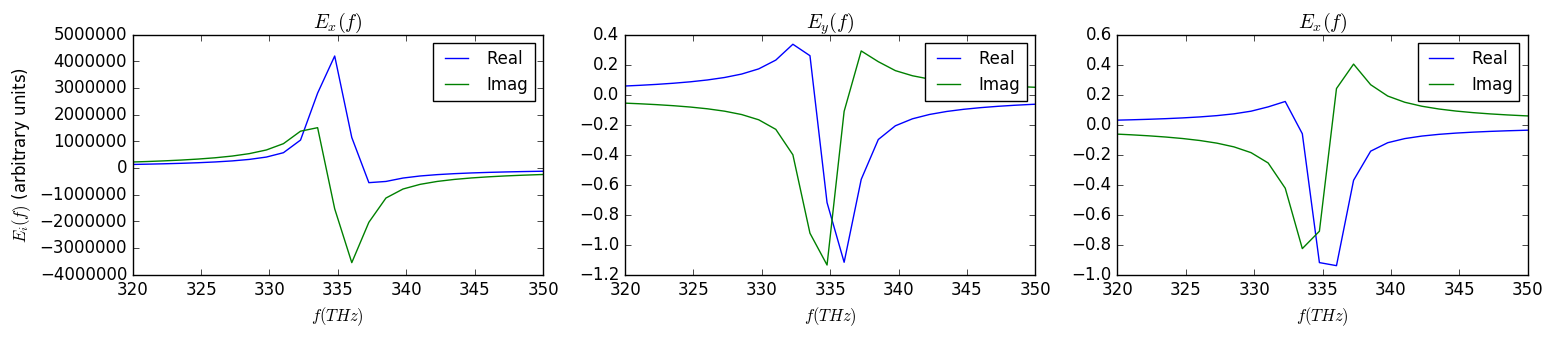

PyObject <matplotlib.legend.Legend object at 0x7efd6ced66d0>

In [3]:
ex_f=fft(ex); ey_f=fft(ey); ez_f=fft(ez);
#ex_f=fftshift(ex_f); ey_f=fftshift(ey_f); ez_f=fftshift(ez_f); # Have to shift the frequency domain data for complex singal. See: http://www.exegetic.biz/blog/2015/10/monthofjulia-day-37-fourier-techniques/ 
freq_scale=linspace(0,1/deltaT,lent)/1e12;
figure(figsize=(18,3))
subplot(1,3,1)
plot(freq_scale,real(ex_f))
plot(freq_scale,imag(ex_f))
xlabel(L"f (THz)")
xlim([320,350])
ylabel(L"$E_i(f)$ (arbitrary units)")
title("\$E_x(f)\$")
legend(["Real", "Imag"],fontsize=12)

subplot(1,3,2)
plot(freq_scale,real(ey_f))
plot(freq_scale,imag(ey_f))
xlabel(L"f(THz)")
xlim([320,350])
#xticks(linspace(800,960,5))
title("\$E_y(f)\$")
legend(["Real", "Imag"],fontsize=12)

subplot(1,3,3)
plot(freq_scale,real(ez_f))
plot(freq_scale,imag(ez_f))
xlabel(L"f(THz)")
xlim([320,350])
#xticks(linspace(800,960,5))
title("\$E_x(f)\$")
legend(["Real", "Imag"],fontsize=12)

As we can see, the peak frequency is around $f_0=335THz$ or central wavelength at $\lambda_0=895nm$ which correctly corresponds to the input light signal. 

## The time-evolution of the dipole source
To calculate the Green function at the dipole position, we need to use the time-evolution of the dipole source which is essentially described by the following function
$$E_i = E_0 \exp{\left[-i\omega t-\frac{(t-t_0)^2}{2w^2}\right]},$$
where $w=\frac{1}{df}$ is the time width of the signal and $df$ is the frequency width in the special units defined by MEEP. In the simulation script, the center of time $t_0$ is defined by 
$t_0=t_{start}+\Delta t_{cutoff}$ with the starting time $t_{start}=0$ and the cutoff time $t_{cutoff}=5$ by default. So, the signal of the input component will look like the following.

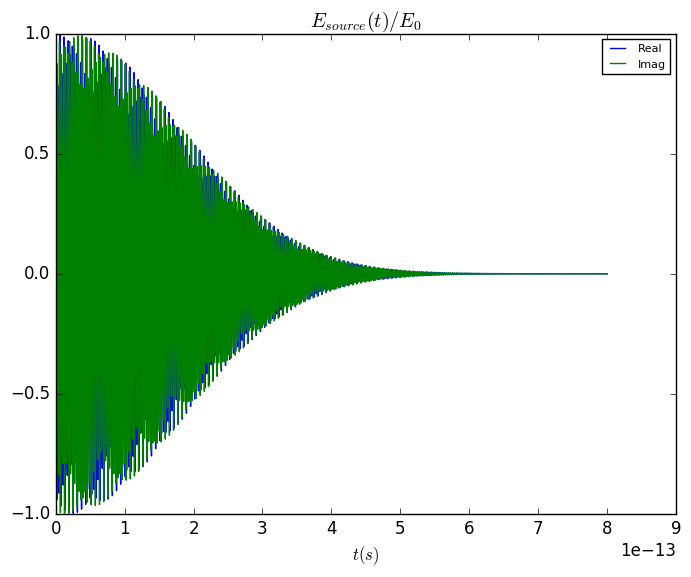

1.6678204759907603e-13

In [4]:
df=deltaT; 
w=1/0.02*t_unit;
lambda0=0.895e-6;
ω=2.*pi*c/lambda0 
t_cutoff=5*t_unit; t_0=t_cutoff;
t=t*t_unit;
E_source=exp(-im*ω*t-(t-t_0).^2/2/w^2)
figure;
plot(t,real(E_source))
plot(t,imag(E_source))
title("\$E_{source}(t)/E_0\$")
xlabel(L"t(s)")
#ylabel(L"$E_y$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)
w

Now, we use the FDTD simulation to calculate a Gaussian dipole source decaying in the time domain to compare with the analytical expression of the dipole source defined based on the MEEP manual as shown above to get the scaling factor of the complex amplitude. 
The FDTD simulation is performed using the same set of computing parameters as the waveguide case (actually using the square waveguide case for the data below) except that the dipole source is completely in vacuum and oscillating along $x$-axis.
We find the field amplitude scaling factor by plotting out and fitting the first a few periods of time-series signal.

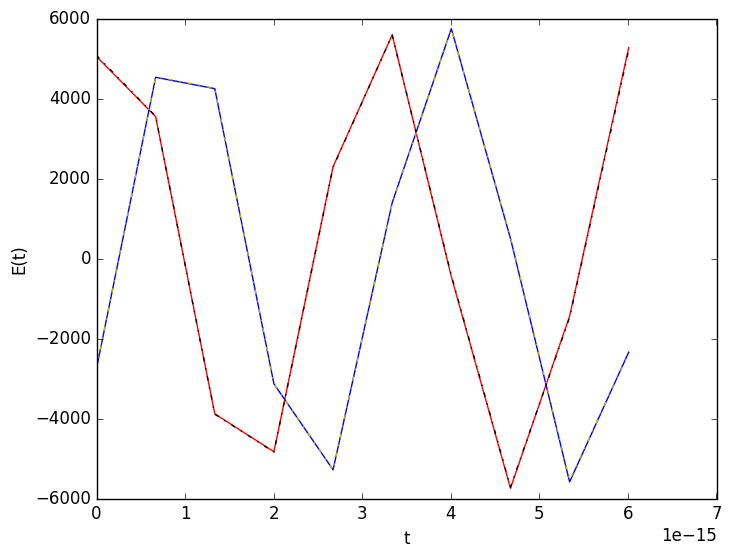

In [5]:
using HDF5
# Load dipole simulation data using vacuum as the environmental material.
ex_vac = h5read("data/vacuum-Ert-240.h5", "ex.r") + im*h5read("data/vacuum-Ert-240.h5", "ex.i");
ey_vac = h5read("data/vacuum-Ert-240.h5", "ey.r") + im*h5read("data/vacuum-Ert-240.h5", "ey.i");
ez_vac = h5read("data/vacuum-Ert-240.h5", "ez.r") + im*h5read("data/vacuum-Ert-240.h5", "ez.i");
ex_vac = ex_vac[end:-1:1]; ey_vac = ey_vac[end:-1:1]; ez_vac = ez_vac[end:-1:1];
# Change the scaling factor and initial phase shift for the dipole source amplitude to make both the analytical and numerical curves match up.
E_source_fit=(5.78e+3exp(1.*pi/6.3.*im))*E_source;
# Plot out the fitted analytical solution of the dipole source signal against the simulated data.
using PyPlot
figure;
ax = gca()
cp = ax[:plot](t[1:10],real(E_source_fit[1:10]),"r-")
cp = ax[:plot](t[1:10],-imag(E_source_fit[1:10]),"b-") # There is a sign difference for the imaginary part.
cp = ax[:plot](t[1:10],real(ex_vac[1:10]),"k-.")
cp = ax[:plot](t[1:10],imag(ex_vac[1:10]),"y-.")
xlabel("t")
ylabel("E(t)")
# Correct the sign flip of the imaginary part of the fitted dipole signal function.
E_source_fit=real(E_source_fit)-im*imag(E_source_fit);

Now, let's look at the signal in the frequency domain.

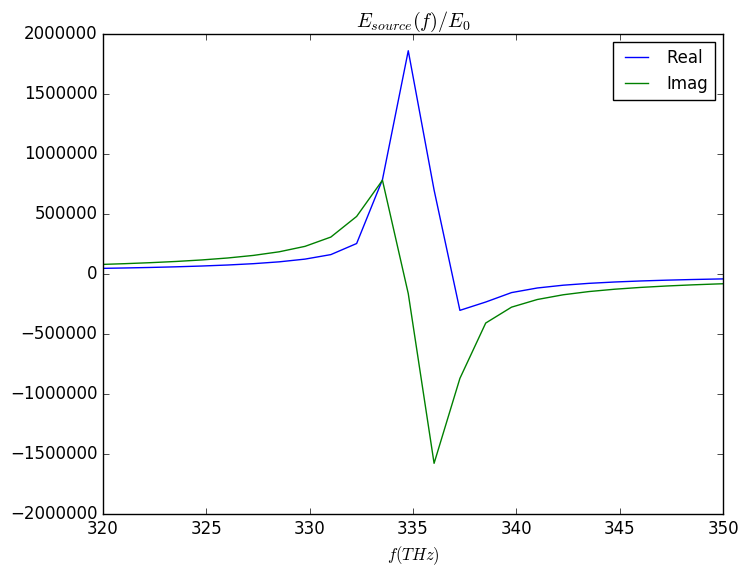

PyObject <matplotlib.legend.Legend object at 0x7efd6c9aa290>

In [6]:
E_source_f = fft(E_source_fit)
#E_source_f = fftshift(E_source_fit) # Shift the data as before.
figure;
plot(freq_scale,real(E_source_f))
plot(freq_scale,imag(E_source_f))
title("\$E_{source}(f)/E_0\$")
xlabel(L"f (THz)")
xlim([320,350])
#ylim([-1.2e4,1.2e4])
#ylabel(L"$E_y$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=12)

The signal in MEEP is a complex function and is different from other software. 
By adding a proper scaling factor including a phase shift over the field amplitude and a sign flip over the imaginary part of the expected analytical expression of the dipole source signal, the frequency domain curve looks about right with a central frequency at $f_0=335$THz as expected.

## The Green's function and decay rates
We can calculate the Green's function in the frequency domain using the detected field and signal components obtained earlier. Only the imaginary part is related to us, and the Green's function we can obtain is normalized to the dipole excited in free space.

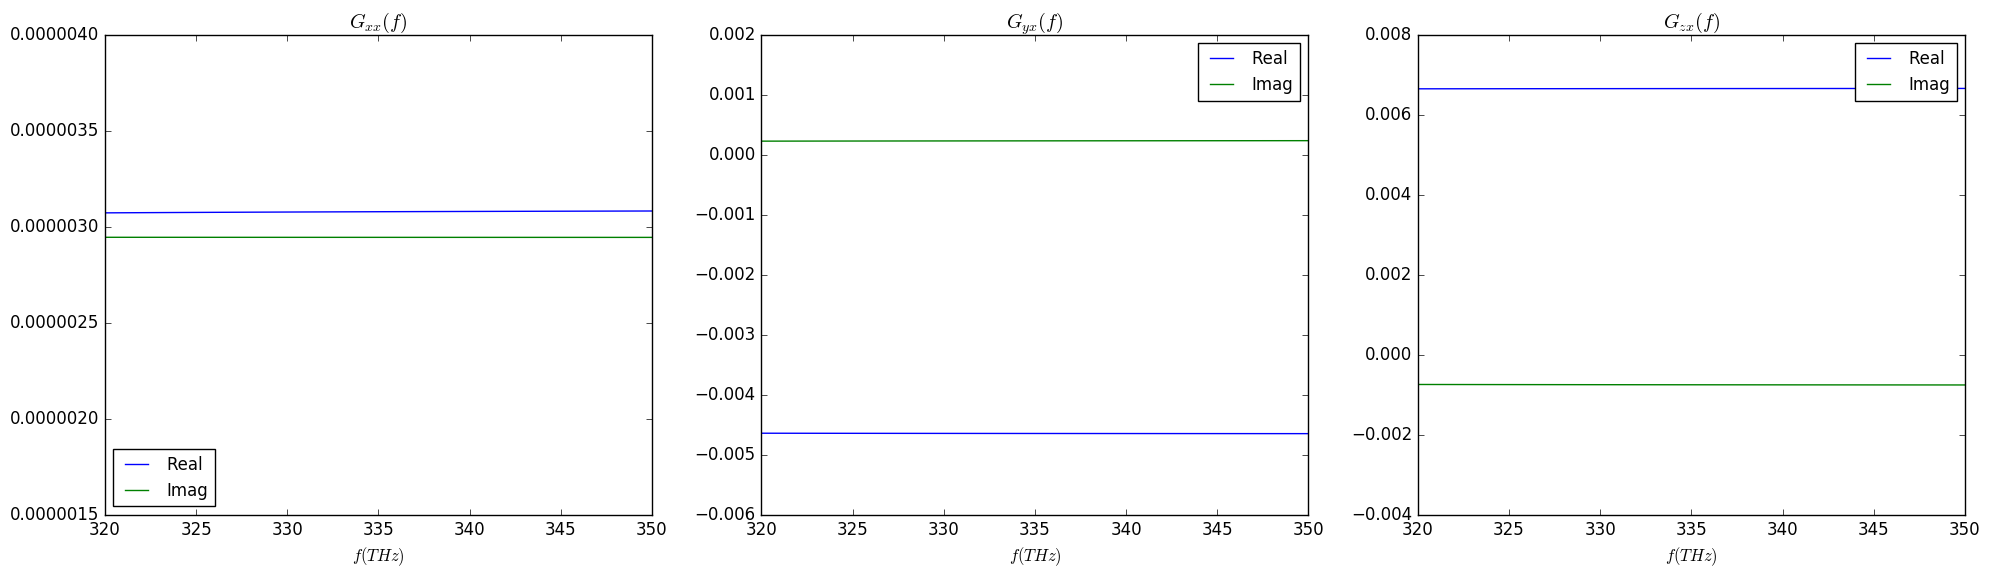

PyObject <matplotlib.legend.Legend object at 0x7efd6b0a2b50>

In [16]:
Gxx=ex_f./(E_source_f)
Gyx=ey_f./(E_source_f)
Gzx=ez_f./(E_source_f)

figure(figsize=(24,6))
subplot(1,3,1)
plot(real(Gxx))
plot(imag(Gxx))
title("\$G_{xx}(f)\$")
xlabel(L"f(THz)")
xlim([320,350])
#xticks(linspace(800,960,5))
#ylabel(L"$G_{xx}/G_0$ (arbitrary units)")
#ylim([-2e-2,2e-2])
legend(["Real", "Imag"],fontsize=12,loc="lower left")
#legend(["Imag"],fontsize=8)

subplot(1,3,2)
plot(real(Gyx))
plot(imag(Gyx))
title("\$G_{yx}(f)\$")
xlabel(L"f(THz)")
xlim([320,350])
#xticks(linspace(800,960,5))
#ylabel(L"$G_{yx}/G_0$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=12)

subplot(1,3,3)
plot(real(Gzx))
plot(imag(Gzx))
title("\$G_{zx}(f)\$")
xlabel(L"f(THz)")
xlim([320,350])
#ylim([-10,10])
#xticks(linspace(800,960,5))
#ylabel(L"$G_{zx}/G_0$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=12)

Above shows the local Green's function elements at the dipole position due to the dipole oscillating along x-direction. 
More details on the units of electric field defined in MEEP can be found at: http://meepunits.wikia.com/wiki/Meep_unit_transformation_Wiki and http://ab-initio.mit.edu/wiki/index.php/Meep_Introduction. 
It is also helpful to use a finer gridding scale in the simulation to obtain the accurate Purcell factor value since the FDTD method yields field components which may not be at the chosen place due to the way it meshes. 

# Other Green's function tensor elements

With a dipole orientated along $y$- and $z$-directions, one can obtain the other elements of the Green's function tensor in the frequency domain. 

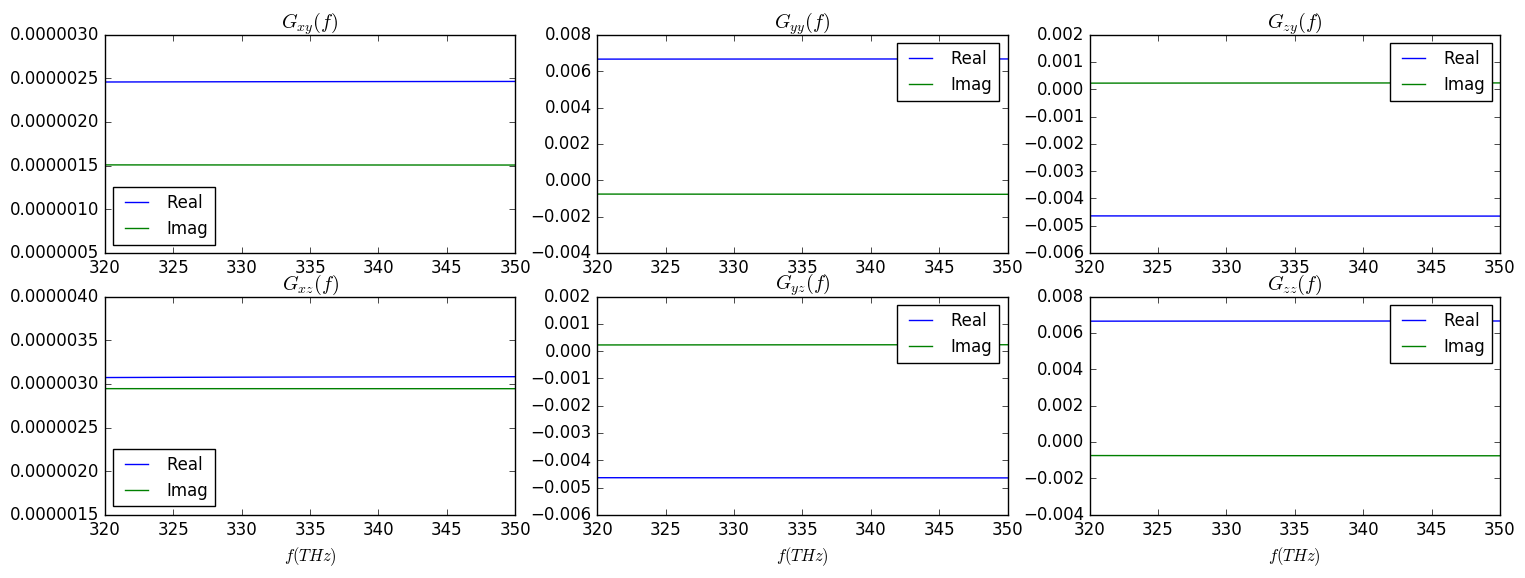

In [13]:
# With a dipole orientated along y-axis.
ex = h5read("data/nanofiber-Ert-ey.h5", "ex.r") + im*h5read("data/nanofiber-Ert-ey.h5", "ex.i")
ey = h5read("data/nanofiber-Ert-ey.h5", "ey.r") + im*h5read("data/nanofiber-Ert-ey.h5", "ey.i")
ez = h5read("data/nanofiber-Ert-ey.h5", "ez.r") + im*h5read("data/nanofiber-Ert-ey.h5", "ez.i")
ex = ex[end:-1:1]; ey = ey[end:-1:1]; ez = ez[end:-1:1];
ex_f=fft(ex); ey_f=fft(ey); ez_f=fft(ez);
Gxy=ex_f./(E_source_f);
Gyy=ey_f./(E_source_f);
Gzy=ez_f./(E_source_f);

# With a dipole orientated along z-axis.
ex = h5read("data/nanofiber-Ert-ez.h5", "ex.r") + im*h5read("data/nanofiber-Ert-ez.h5", "ex.i")
ey = h5read("data/nanofiber-Ert-ez.h5", "ey.r") + im*h5read("data/nanofiber-Ert-ez.h5", "ey.i")
ez = h5read("data/nanofiber-Ert-ez.h5", "ez.r") + im*h5read("data/nanofiber-Ert-ez.h5", "ez.i")
ex = ex[end:-1:1]; ey = ey[end:-1:1]; ez = ez[end:-1:1];
ex_f=fft(ex); ey_f=fft(ey); ez_f=fft(ez);
Gxz=ex_f./(E_source_f);
Gyz=ey_f./(E_source_f);
Gzz=ez_f./(E_source_f);

# Plot the corresponding GFT elements.
figure(figsize=(18,6))
subplot(2,3,1)
plot(real(Gxy))
plot(imag(Gxy))
title("\$G_{xy}(f)\$")
#xlabel(L"f(THz)")
xlim([320,350])
#xticks(linspace(800,960,5))
#ylabel(L"$G_{xx}/G_0$ (arbitrary units)")
#ylim([-20,20])
legend(["Real", "Imag"],fontsize=12,loc="lower left")
#legend(["Imag"],fontsize=8)

subplot(2,3,2)
plot(real(Gyy))
plot(imag(Gyy))
title("\$G_{yy}(f)\$")
#xlabel(L"f(THz)")
xlim([320,350])
#xticks(linspace(800,960,5))
#ylabel(L"$G_{yx}/G_0$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=12)

subplot(2,3,3)
plot(real(Gzy))
plot(imag(Gzy))
title("\$G_{zy}(f)\$")
#xlabel(L"f(THz)")
xlim([320,350])
#ylim([-10,10])
#xticks(linspace(800,960,5))
#ylabel(L"$G_{zx}/G_0$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=12)

subplot(2,3,4)
plot(real(Gxz))
plot(imag(Gxz))
title("\$G_{xz}(f)\$")
xlabel(L"f(THz)")
xlim([320,350])
#xticks(linspace(800,960,5))
#ylabel(L"$G_{xx}/G_0$ (arbitrary units)")
#ylim([-20,20])
legend(["Real", "Imag"],fontsize=12,loc="lower left")
#legend(["Imag"],fontsize=8)

subplot(2,3,5)
plot(real(Gyz))
plot(imag(Gyz))
title("\$G_{yz}(f)\$")
xlabel(L"f(THz)")
xlim([320,350])
#xticks(linspace(800,960,5))
#ylabel(L"$G_{yx}/G_0$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=12)

subplot(2,3,6)
plot(real(Gzz))
plot(imag(Gzz))
title("\$G_{zz}(f)\$")
xlabel(L"f(THz)")
xlim([320,350])
#ylim([-10,10])
#xticks(linspace(800,960,5))
#ylabel(L"$G_{zx}/G_0$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=12)